# Import Libraries and CSV Data
##### Debugging or Troubleshooting Code in this notebook was helped by OpenAI's ChatGPT (January 2025)

#### This notebook uses no text data
##### The models in this notebook got better results but using video and channel specific data
- Excluded Data

    - `v_favorites`,`v_privacy_status`,`c_channel_id`,`v_video_id`,`c_channel_upload_playlist`,
    
    - `v_description`,`c_channel_title`,`v_tags`,`v_title`

In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# Read in our CSV data
file_path = 'data/english_video_data.csv'
videos_df = pd.read_csv(file_path)
videos_df.head()

,c_channel_id,v_video_id,v_date_publishedAt,v_time_publishedAt,c_channel_title,c_channel_upload_playlist,c_channel_subCount,c_channel_videoCount,c_channel_viewCount,v_category_id,...,v_comment_count,v_likes,v_favorites,v_views,v_definition,v_duration,v_caption,v_age_restricted,v_privacy_status,v_made_for_kids
0,UC295-Dw_tDNtZXFeAPAW6Aw,oGga7hZypCs,2024-09-02,11:00:48,5-Minute Crafts,UU295-Dw_tDNtZXFeAPAW6Aw,81100000,7445,27960945663,26,...,28,442,0,76602,hd,2:03:35,False,Not Restricted,public,False
1,UC295-Dw_tDNtZXFeAPAW6Aw,pkzIiXkRxB0,2024-08-30,11:00:54,5-Minute Crafts,UU295-Dw_tDNtZXFeAPAW6Aw,81100000,7445,27960945663,26,...,21,1165,0,341133,hd,2:01:48,False,Not Restricted,public,False
2,UC295-Dw_tDNtZXFeAPAW6Aw,TUS8vZaHNds,2024-08-31,11:00:26,5-Minute Crafts,UU295-Dw_tDNtZXFeAPAW6Aw,81100000,7445,27960945663,26,...,43,1374,0,222425,hd,1:00:04,False,Not Restricted,public,False
3,UC295-Dw_tDNtZXFeAPAW6Aw,rBzKTkUG3Wk,2024-08-31,13:00:57,5-Minute Crafts,UU295-Dw_tDNtZXFeAPAW6Aw,81100000,7445,27960945663,26,...,19,274,0,40821,hd,1:01:09,False,Not Restricted,public,False
4,UC295-Dw_tDNtZXFeAPAW6Aw,XHQP6mut8YI,2024-09-01,11:00:36,5-Minute Crafts,UU295-Dw_tDNtZXFeAPAW6Aw,81100000,7445,27960945663,26,...,27,485,0,82374,hd,0:20:16,False,Not Restricted,public,False


## Data Preprocessing

In [2]:
# Remove some columns that we wont need in this model
videos_df_2 = videos_df.drop(['v_favorites','v_privacy_status','c_channel_id','v_video_id','c_channel_upload_playlist',
                              'v_description'], axis=1)

In [3]:
# Change the way duration, date published, and time published are formatted
videos_df_2['v_date_publishedAt'] = videos_df_2['v_date_publishedAt'].astype('datetime64[s]')
videos_df_2['v_time_publishedAt'] = videos_df_2['v_time_publishedAt'].astype('datetime64[s]')

videos_df_2['v_year'] = videos_df_2['v_date_publishedAt'].dt.year
videos_df_2['v_mont'] = videos_df_2['v_date_publishedAt'].dt.month
videos_df_2['v_day'] = videos_df_2['v_date_publishedAt'].dt.day
videos_df_2['v_hour'] = videos_df_2['v_time_publishedAt'].dt.hour
videos_df_2['v_minute'] = videos_df_2['v_time_publishedAt'].dt.minute
videos_df_2['v_second'] = videos_df_2['v_time_publishedAt'].dt.second

videos_df_2.drop(['v_date_publishedAt', 'v_time_publishedAt'], axis=1, inplace=True)

videos_df_2['v_duration_time'] = pd.to_timedelta(videos_df_2['v_duration'])

videos_df_2['v_duration_time'] = videos_df_2['v_duration_time'].dt.total_seconds()

videos_df_2.drop(['v_duration'], axis=1, inplace=True)

In [4]:
# list of all category names from Youtube with their ID's
categories = {
    1: "Film & Animation",
    2: "Autos & Vehicles",
    10: "Music",
    15: "Pets & Animals",
    17: "Sports",
    18: "Short Movies",
    19: "Travel & Events",
    20: "Gaming",
    21: "Videoblogging",
    22: "People & Blogs",
    23: "Comedy",
    24: "Entertainment",
    25: "News & Politics",
    26: "Howto & Style",
    27: "Education",
    28: "Science & Technology",
    29: "Nonprofits & Activism",
    30: "Movies",
    31: "Anime/Animation",
    32: "Action/Adventure",
    33: "Classics",
    34: "Comedy",
    35: "Documentary",
    36: "Drama",
    37: "Family",
    38: "Foreign",
    39: "Horror",
    40: "Sci-Fi/Fantasy",
    41: "Thriller",
    42: "Shorts",
    43: "Shows",
    44: "Trailers"
}

# Function to change category id to the category name
def name_categories(df, category_dict):
    for index, row in df.iterrows():
        if row['v_category_id'] in [23, 10, 17, 15, 19]:
            df.at[index, 'v_category_id'] = "other"
        elif row['v_category_id'] in category_dict:
            df.at[index, 'v_category_id'] = category_dict[row['v_category_id']]

    return df

In [5]:
# Uses function above to change category
videos_df_cats = name_categories(videos_df_2, categories)

C:\Users\papad\AppData\Local\Temp\ipykernel_25520\917203685.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Howto & Style' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[index, 'v_category_id'] = category_dict[row['v_category_id']]


In [6]:
# This will randomize the order of our datafram since the CSV that was read in was sorted
videos_df_cats = videos_df_cats.sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
# Get dummies for certain columns
videos_df_dummies = pd.get_dummies(data=videos_df_cats, columns=['v_category_id','v_definition','v_caption','v_age_restricted','v_made_for_kids'],dtype=int)

In [8]:
# Function to bucket our views column for our models to use as target(y)
def bucket_views(df, column_name):
    bins = [-1, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, float("inf")]
    labels = [
        "Very Low (0 - 1K)",
        "Low (1K - 5K)",
        "Moderate (5K - 10K)",
        "Growing (10K - 50K)",
        "Established (50K - 100K)",
        "Popular (100K - 500K)",
        "Trending (500K - 1M)",
        "Viral (1M+)"
    ]
    df["view_bucket"] = pd.cut(df[column_name], bins=bins, labels=labels, right=True)
    
    return df

In [9]:
# Use the function bucket_views to bucket each video viewcount
bucket_video_df = bucket_views(videos_df_dummies, 'v_views')
bucket_video_df.drop(columns=['v_views'], axis=1, inplace =True)
bucket_video_df['view_bucket'].value_counts()

view_bucket
Low (1K - 5K)               6825
Very Low (0 - 1K)           5072
Growing (10K - 50K)         4546
Moderate (5K - 10K)         3334
Popular (100K - 500K)       1235
Established (50K - 100K)    1039
Viral (1M+)                  251
Trending (500K - 1M)         214
Name: count, dtype: int64

In [10]:
# Use labelencoder to change bucket names to numeric
encoder = LabelEncoder()
bucket_video_df["video_views_bucket_encoded"] = encoder.fit_transform(bucket_video_df["view_bucket"])

In [11]:
# Drop columns that wont be used
bucket_video_df.drop(columns=['view_bucket'], axis=1, inplace =True)

In [12]:
# Drop columns that wont be used
bucket_video_df = bucket_video_df.drop(columns=['c_channel_title', 'v_tags', 'v_title','v_caption_False','v_made_for_kids_False'])

## Beginning of Model Building

In [13]:
# Split our data into Features and Target
y = bucket_video_df['video_views_bucket_encoded']
X = bucket_video_df.drop(columns=['video_views_bucket_encoded'])

In [14]:
# Split our data into testing and training data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [15]:
# Make sure shapes match up
print("X_train shape before transformation:", X_train.shape)
print("X_test shape before transformation:", X_test.shape)

X_train shape before transformation: (18012, 29)
X_test shape before transformation: (4504, 29)


In [17]:
# Function to get Feature names and display the top 20 by value
def display_top_features(columns_used, model):
    # Get feature names
    feature_names = list(columns_used)

    # Get the importance of each feature
    importances = model.feature_importances_

    # Sort feature by importance
    indices = np.argsort(importances)[::-1]

    # Get the top 20 by importance
    top_20_indices = indices[:20]
    feature_names = [feature_names[i] for i in top_20_indices]
    combined_importances = importances[top_20_indices]

    # Display a bar graph showing top 20 by importance
    plt.figure(figsize=(10,6))
    plt.title("Top 20 Feature Importance")
    plt.bar(range(len(combined_importances)), combined_importances, align="center")
    plt.xticks(range(len(combined_importances)), feature_names, rotation=90)
    plt.show()

    return

### Random Forest Model

In [18]:
# Random Forest Hyperparameters
rf_model = RandomForestClassifier(random_state=42)

# Train the model and get predictions
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

# Show accuracy, cofusion matric, and classification report
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print(f"Accuracy: {rf_accuracy*100:.3f}%")
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_y_pred))
print("Classification Report:\n", classification_report(y_test, rf_y_pred))

# Save the model
joblib.dump(rf_model, "model/rf_model.pkl")

Accuracy: 73.224%
Confusion Matrix:
 [[  72  109    6    1   36    0    0    0]
 [  23  711   44  113    2    0    3    0]
 [   1    9 1099   85    0    0  155    0]
 [   0  146  196  349    0    0    2    0]
 [  40   39    2    3  183    2    0    1]
 [   0    1    0    0   29    9    0    4]
 [   0    0  127    0    0    0  841    0]
 [   1    0    1    0   19    6    0   34]]
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.32      0.40       224
           1       0.70      0.79      0.74       896
           2       0.75      0.81      0.78      1349
           3       0.63      0.50      0.56       693
           4       0.68      0.68      0.68       270
           5       0.53      0.21      0.30        43
           6       0.84      0.87      0.85       968
           7       0.87      0.56      0.68        61

    accuracy                           0.73      4504
   macro avg       0.69      0.59      0.62      450

['model/rf_model.pkl']

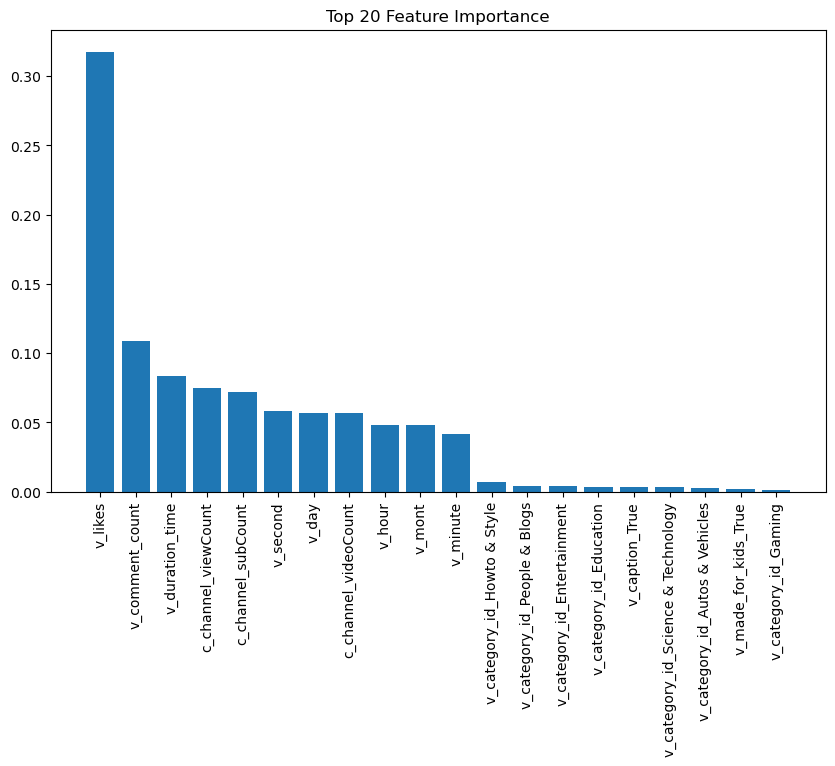

In [19]:
# Display top 20 features
display_top_features(X_train.columns,rf_model)

### XGBoost Model

In [20]:
# XGB Hyperparameters
xgb_model = XGBClassifier(random_state=42, max_depth=20)

# Train the model and get predictions
xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_test)

# Show accuracy, cofusion matric, and classification report
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
print(f"Accuracy: {xgb_accuracy*100:.3f}%")
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_y_pred))
print("Classification Report:\n", classification_report(y_test, xgb_y_pred))

# Save the model
xgb_model.save_model("model/xgb_model.json")
joblib.dump(xgb_model, "model/xgb_model.pkl")

Accuracy: 74.556%
Confusion Matrix:
 [[  94   76    3    6   45    0    0    0]
 [  28  706   38  118    5    0    1    0]
 [   0   11 1083  107    0    0  148    0]
 [   0  134  174  383    0    0    2    0]
 [  40   27    2    0  191    5    0    5]
 [   0    1    0    0   20   14    0    8]
 [   0    0  122    0    0    0  846    0]
 [   1    1    0    0   10    8    0   41]]
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.42      0.49       224
           1       0.74      0.79      0.76       896
           2       0.76      0.80      0.78      1349
           3       0.62      0.55      0.59       693
           4       0.70      0.71      0.71       270
           5       0.52      0.33      0.40        43
           6       0.85      0.87      0.86       968
           7       0.76      0.67      0.71        61

    accuracy                           0.75      4504
   macro avg       0.69      0.64      0.66      450

['model/xgb_model.pkl']

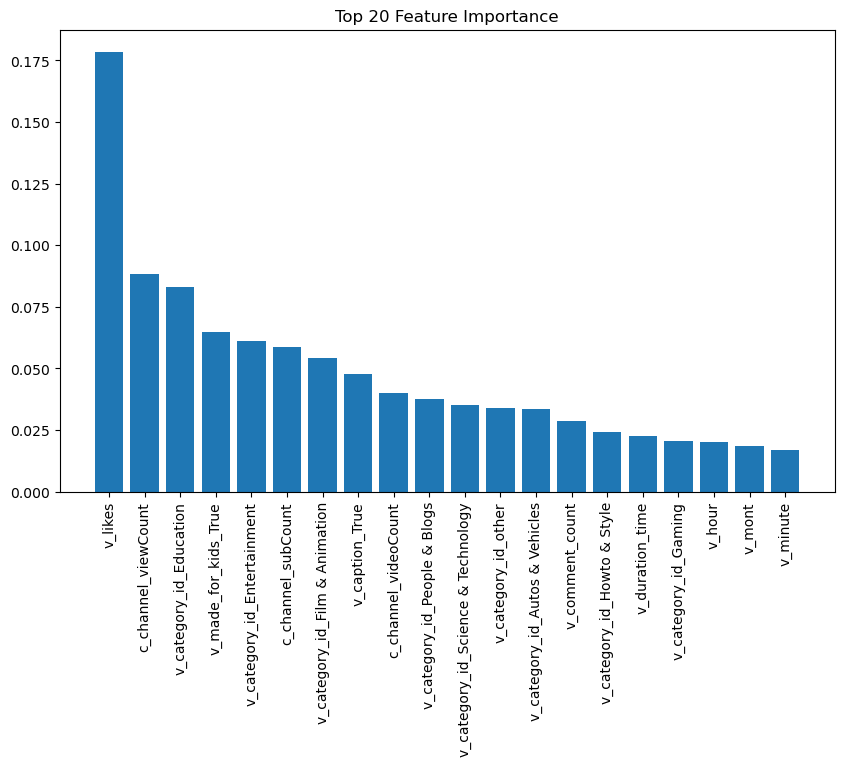

In [21]:
# Display top 20 features
display_top_features(X_train.columns,xgb_model)

### Decision Tree Model

In [22]:
# Decision Tree Hyperparameters
dt_model = DecisionTreeClassifier(
    random_state=42,
    min_samples_split=9,
    min_samples_leaf=1,
    max_depth=10,
    criterion='gini'
)

# Train the model and get predictions
dt_model.fit(X_train, y_train)
dt_y_pred = dt_model.predict(X_test)

# Show accuracy, cofusion matric, and classification report
dt_accuracy = accuracy_score(y_test, dt_y_pred)
print(f"Accuracy: {dt_accuracy*100:.3f}%")
print("Confusion Matrix:\n", confusion_matrix(y_test, dt_y_pred))
print("Classification Report:\n", classification_report(y_test, dt_y_pred))

joblib.dump(xgb_model, "model/dt_model.pkl")

Accuracy: 69.560%
Confusion Matrix:
 [[  83   74    4    6   56    1    0    0]
 [  34  634   36  177    9    0    6    0]
 [   0   24 1020  126    0    0  179    0]
 [   1  159  170  360    0    0    3    0]
 [  52   33    3    1  171    8    0    2]
 [   2    1    0    0   23    9    0    8]
 [   0    1  148    2    0    0  817    0]
 [   1    2    0    0   11    8    0   39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.37      0.42       224
           1       0.68      0.71      0.70       896
           2       0.74      0.76      0.75      1349
           3       0.54      0.52      0.53       693
           4       0.63      0.63      0.63       270
           5       0.35      0.21      0.26        43
           6       0.81      0.84      0.83       968
           7       0.80      0.64      0.71        61

    accuracy                           0.70      4504
   macro avg       0.63      0.58      0.60      450

['model/dt_model.pkl']

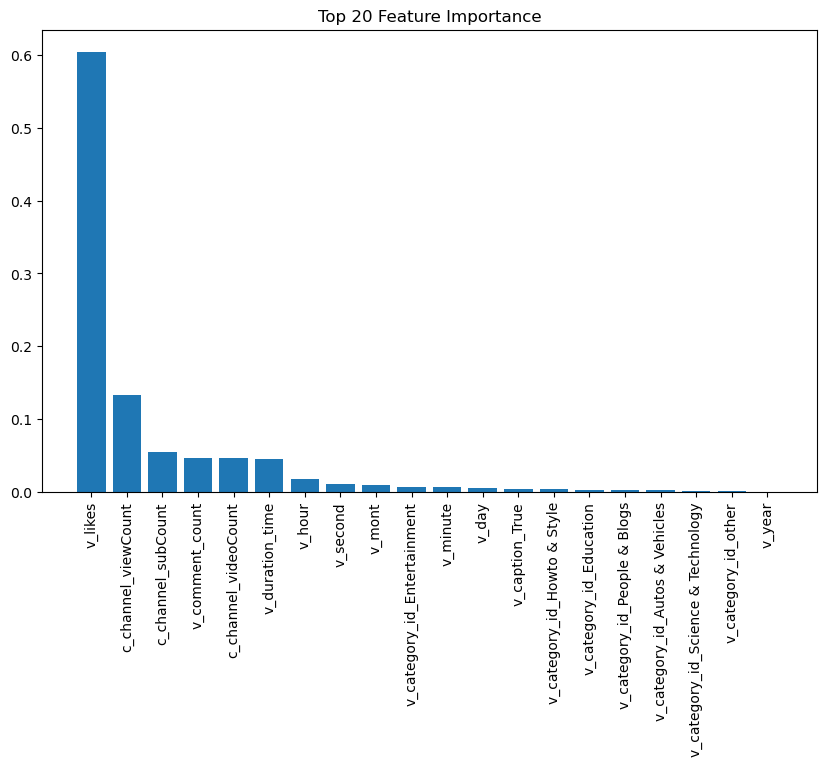

In [23]:
# Display top 20 features
display_top_features(X_train.columns,dt_model)